Final Correctness of Hypothesis:  58
Total iterations:  99
Final Normalized Weights: [0.08069481 0.49001002 1.        ]


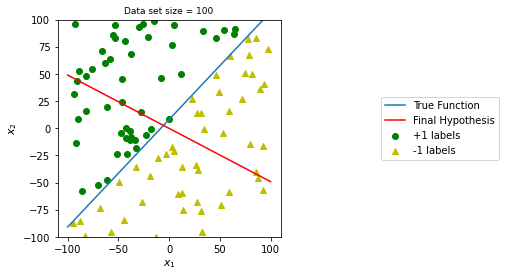

True weights of Target Function:  [-8.09392265 -0.98895028  1.        ]
Eta =  100  Accuracy =  62.83
Final Correctness of Hypothesis:  53
Total iterations:  99
Final Normalized Weights: [0.05366481 0.6086189  1.        ]


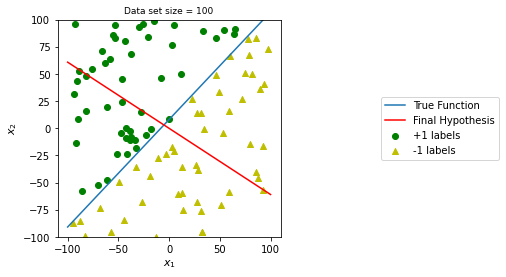

True weights of Target Function:  [-8.09392265 -0.98895028  1.        ]
Eta =  1  Accuracy =  59.82
Final Correctness of Hypothesis:  51
Total iterations:  99
Final Normalized Weights: [0.08837265 0.81833896 1.        ]


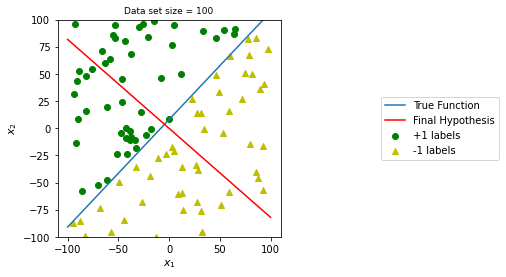

True weights of Target Function:  [-8.09392265 -0.98895028  1.        ]
Eta =  0.01  Accuracy =  55.02
Final Correctness of Hypothesis:  95
Total iterations:  99
Final Normalized Weights: [-0.03127311 -0.90899602  1.        ]


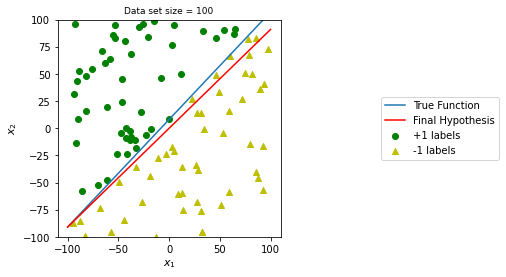

True weights of Target Function:  [-8.09392265 -0.98895028  1.        ]
Eta =  0.0001  Accuracy =  96.26


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 16 16:25:42 2022

@author: Bharadwaj Chukkala | 118341705 | bchukkal@umd.edu
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

def adaline(points, dim, max_iterations, use_adaline=False, 
               eta = 1, randomize=False, print_out = True):
    '''
    Def: Adapative Linear Neuron, a variant of perceptron used in this case for #classification
    Param 1: points = Dataframe values for performing algorithm
    Param 2: dim = dimensions of the input data
    '''
    w = np.zeros(dim+1) #introducing initial weights
    xs, ys = points[:,:dim+1], points[:,dim+1] #Inputs and Corresponding outputs extracted from dataframe
    num_points = points.shape[0] #Number of Inputs 
    # Iterating through the number of iteration by selecting random points
    for iteration in range(max_iterations):
        correctly_predicted_ids=  []
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx] #inputs and corresponding outputs
            st = np.dot(w.T, x) #signal_function
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error we bound the signal at -100
                st = -100
            threshold = 1 if use_adaline else 0 #adaline can learn without the algorithm making errors
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                break #PLA Variation picks one example at each iteration
            else:
                correctly_predicted_ids.append(idx)
        if len(correctly_predicted_ids) == num_points:
            break
    
    c = 0 #correctness
    zipped_matrix = zip(xs, ys) #Input and Output clubbed for brevity
    for x, y in zipped_matrix:
        prod = np.dot(w.T, x)*y 
        if prod > 0:
            c +=1
    w = w/w[-1]
    if print_out:
        print('Final Correctness of Hypothesis: ', c)
        print('Total iterations: ', iteration)
        print('Final Normalized Weights:', w)
    return w, iteration
    

def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    '''
    Def: The function generates random numbers to help generate a dataframe
    Param 1: N = Number of Data points
    Param 2: dim = dimensions of the input data
    Param 3: num_grid_points = number of grid points in the plane
    Param 4: lb = Lower Bound for the input Data Points
    Param 5: ub = Upper Bound for the input Data Points
    '''
    rand_ints = np.random.randint(num_grid_points, size =(N, dim))
    init_lb = 0
    zero_to_one_points = (rand_ints - init_lb)/(num_grid_points -1 -init_lb)
    res = lb + (ub - lb)*zero_to_one_points
    return res

def generate_random_coeffs(dim):
    '''
    Def: Generates random weights given the dimensions
    Param 1: dim = dimension of the input data
    '''
    rn = generate_random_numbers(1, dim, 1000, -10, 10)
    return rn

def true_f(x, coeffs):
    '''
    Def: A helper function to generate the true function
    Param 1: x = input
    Param 2: coeffs = weights for each input
    '''
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())

def generate_two_classes(N, dim, true_function, rn_func):
    '''
    Def: Function that generates two classes to be classified
    Param 1: N = Number of Datapoints for each class
    Param 2: D = Dimensions of the input data
    Param 3: true_function = Target Function that classifies the data
    Param 4: rn_func = Random Function that works according to use case with constrained params
    '''
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_function(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_function(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)    

def generate_dataframe(N, dim,true_function, rn_func):
    '''
    Def: A Fucntion that generates the dataframe using the two classes of data
    Param 1: N = Number of Datapoints
    Param 2: dim = Dimension of the input data
    Param 3: true_function = A Target Functon that classifies the data
    Param 4: rn_func = Random Function that works according to use case with constrained params
    '''
    cls1, cls2 = generate_two_classes(N/2, dim, true_function, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df

def fitness_test(test_df, norm_g):
    '''
    Def: A Utility Function that tests the final weights on a data frame and measures the accuracy of model
    Param 1: test_df = A test data frame to calculate accuracy
    Param 2: norm_g = Final normalized weights 
    '''
    xs = test_df[['x0', 'x1', 'x2']].values
    ys = test_df['y'].values
    accuracy = 0
    for x, y in zip(xs, ys):
        prod = np.dot(norm_g.T, x)*y
        if prod > 0:
            accuracy +=1
    accuracy = accuracy/100
    return accuracy
    
def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
    '''
    Def:A Function to plot the Dataframe(Classes), True Function, Hypothesis etc
    Param 1: A Range of numbers between lowerbound and upper bound
    Param 2: Dataframe that was generated
    Param 3: norm_coeffs = Weights for the input data
    Param 4: norm_g = Weights that were normalized with the first value
    Param 5: lb = lower bound of data
    Param 6: ub = upper bound of data
    '''
    figsize = plt.figaspect(1)
    f, ax = plt.subplots(1, 1, figsize=figsize)
    cls1_df = df.loc[df['y']==1]
    cls2_df = df.loc[df['y']==-1]
    line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function') 
    pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker="o", c= 'g', label='+1 labels')
    minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker="^", c= 'y', label='-1 labels')
    if norm_g is not None:
        hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

    ax.set_ylabel(r"$x_2$", fontsize=11)
    ax.set_xlabel(r"$x_1$", fontsize=11)
    ax.set_title('Data set size = %s'%N, fontsize=9)
    ax.axis('tight')
    legend_x = 2.0
    legend_y = 0.5
    ax.legend(['True Function', 'Final Hypothesis', 
                '+1 labels', '-1 labels', ], 
                loc='center right', bbox_to_anchor=(legend_x, legend_y))
    #ax.legend(handles=[pluses, minuses], fontsize=9)
    ax.set_ylim(bottom=lb, top=ub)
    plt.show()
    print('True weights of Target Function: ', norm_coeffs)
    

lb,ub = -100, 100 #Bounds
N = 100 #Number of Data points
dim = 2 #Dimensions
num_grid_points = 2000
test_N = 10000 #Test_data_points
coeff_lb, coeff_ub = -10, 10 #Coefficients of bounds
use_adaline, randomize = True, True #Setting parameters for functions
show_plot = True #Setting parameter to display plots
max_iterations=100 #Maximum number of iterations to converge

random_numbers = generate_random_numbers(N, dim, num_grid_points, lb, ub) #Generating random numbers
rn_func = partial(generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub) 
coeffs = generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub) #Weights
norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1] #Normalized Weights
true_function = partial(true_f, coeffs = norm_coeffs) #True function with normalzed weights

df = generate_dataframe(N, dim, true_function, rn_func)
test_df = generate_dataframe(test_N, dim, true_function, rn_func)

x1 = np.arange(lb, ub, 0.01)

for eta in [100, 1, 0.01, 0.0001]:
    norm_g, num_its = adaline(df.values, dim, max_iterations, use_adaline, 
                                 eta, randomize, show_plot)

    if show_plot:
        plot_data(x1, df, norm_coeffs, norm_g, lb, ub)
        
    accuracy = fitness_test(test_df, norm_g)
    print('Eta = ', eta, ' Accuracy = ', accuracy)